<a href="https://colab.research.google.com/github/rfmiotto/optimal-seat-allocation-problem/blob/main/aircraft_seat_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIRCRAFT SEAT ALLOCATION PROBLEM

> **Disclaimer**:
>
> In this notebook, Azul is used purely as a fictional case study to illustrate an optimal seat allocation problem in operations research. All numerical values, profits, capacities, and demand scenarios presented here are entirely hypothetical and do **not** reflect Azul's actual operations or financial data. This example is intended solely for educational purposes.


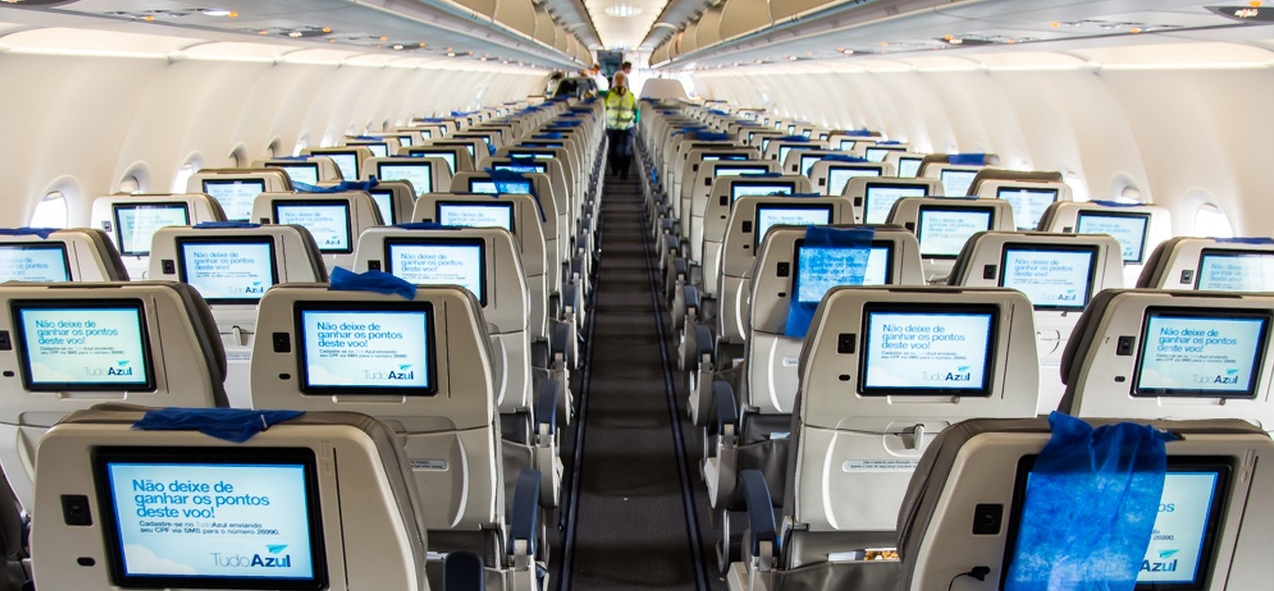

Azul Airlines, one of Brazil's leading carriers, faced significant financial challenges in the aftermath of the COVID-19 pandemic. A combination of high debt levels, rising operational costs, a weakened Brazilian currency, and supply chain disruptions affecting aircraft deliveries and maintenance placed substantial pressure on the airline's finances. In May 2025, Azul filed for bankruptcy protection in New York as part of an effort to restructure its debt and improve its resilience to market volatility, including fluctuations in fuel prices and exchange rates.

These challenges highlight the importance of sound operational decision-making in the airline industry. One critical decision airlines face is how to configure aircraft seating in order to balance capacity utilization and profitability under uncertain and fluctuating demand.

Motivated by this context, we consider a simplified aircraft seat allocation problem inspired by Azul's operations on the high-demand São Paulo-Rio route. The goal is to determine an optimal seating configuration that maximizes expected ticket revenue across different demand scenarios.


## Problem Description

An airline must decide how to partition a new aircraft assigned to the São Paulo-Rio route. The aircraft has a total capacity equivalent to 200 economy-class seats. The airline may divide this capacity among three seating classes:

- **Economy class**, where each seat uses one unit of capacity
- **Business class**, where each seat uses the space of 1.5 economy seats
- **First class**, where each seat uses the space of 2 economy seats

Ticket profits differ by class:

- A first-class ticket generates three times the profit of an economy ticket
- A business-class ticket generates twice the profit of an economy ticket

Once the aircraft is configured, the seating allocation cannot be changed.

Passenger demand is uncertain and varies over time. The airline considers three demand scenarios, assumed to occur with approximately equal frequency:

1. Weekday morning and evening traffic
2. Weekend traffic
3. Weekday midday traffic

Under each scenario, the airline forecasts the maximum number of tickets it could sell in each seating class. These demand estimates are summarized below:

<center>

| Scenario | First-class seats | Business-class seats | Economy-class seats |
| :-- | :-: | :-: | :-: |
| (1) weekday morning and evening | 17 | 50 | 200 |
| (2) weekend | 10 | 22 | 175 |
| (3) weekday midday | 6 | 12 | 150 |
| **Average Scenario** | **11** | **28** | **175** |

</center>

<br>

**Objective and Assumptions:**

The airline's objective is to <ins>maximize total ticket revenue</ins>.

We make the following assumptions:

- The airline does not overbook: tickets sold in each class cannot exceed the number of seats allocated to that class.
- Passengers seeking first-class or business-class seats will not downgrade to a lower class if their preferred option is unavailable.
- Any unsold seats generate no revenue.

By adapting its seating allocation, Azul could better manage its operational costs and increase profitability, which is critical as it works to recover financially and strengthen its position in a competitive market.

## Preamble: Install Pyomo and HiGHS solver


In [1]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import norm

## Problem data


In [3]:
demand = pd.DataFrame(
    {
        "morning and evening": {"F": 17, "B": 50, "E": 200},
        "weekend": {"F": 10, "B": 22, "E": 175},
        "midday": {"F": 6, "B": 12, "E": 150},
    }
).T

capacity = 200
revenue_factor = pd.Series({"F": 3.0, "B": 2.0, "E": 1.0})
seat_factor = pd.Series({"F": 2.0, "B": 1.5, "E": 1.0})

## Analytics

To facilitate this analysis, we will create a helper function called `generate_report()`. This function will allow us to easily assess the impact of any seat allocation by showing key performance metrics for each of the three demand scenarios. Specifically, it will display:

- The number of tickets that can be sold for each class in each scenario.
- The resulting revenue based on the given seat allocation.
- Any unsatisfied demand (referred to as "spillage"), which occurs when demand exceeds the available seats. This is plotted in transparent color.


In [23]:
# Define a global color palette for consistency
COLORS = {"E": "#003049", "B": "#d62828", "F": "#f77f00"}


def generate_report(seats, demand, seat_factor, revenue_factor, name=""):
    """Function to report analytics for any given seat allocation configuration"""

    # Classes of seats (First, Business, Economy)
    classes = seats.index

    # Seat allocation and its equivalent in economy-class seats
    equivalent_seats = pd.DataFrame(
        {
            "Seat Allocation": {c: seats[c] for c in classes},
            "Economy Equivalent Allocation": {c: seats[c] * seat_factor[c] for c in classes},
        }
    ).T
    equivalent_seats["Total"] = equivalent_seats.sum(axis=1)

    display(equivalent_seats.style
            .format("{:.2f}")
            .set_caption(f"{name} - Seat Allocation"))

    # Tickets sold: minimum of available seats and demand for each class
    tickets_sold = pd.DataFrame({c: np.minimum(seats[c], demand[c]) for c in classes})

    print("\n\n\n\n")
    display(tickets_sold.style
            .format("{:.2f}")
            .set_caption(f"{name} - Tickets Sold"))

    # Seats not sold (unsold capacity)
    unsold_seats = pd.DataFrame({c: seats[c] - tickets_sold[c] for c in classes})

    print("\n\n\n\n")
    display(unsold_seats.style
            .format("{:.2f}")
            .set_caption(f"{name} - Unsold Seats"))

    # Spillage: Unmet demand (where demand exceeds available tickets)
    spillage = demand - tickets_sold
    spillage[spillage < 0] = 0  # Set negative spillage to 0 (no negative demand)

    print("\n\n\n\n")
    display(spillage.style
            .format("{:.2f}")
            .set_caption(f"{name} - Spillage (Unmet Demand)"))

    # Revenue computation: Multiply tickets sold by the corresponding revenue factor
    revenue = tickets_sold.dot(revenue_factor)

    print(f"\n\n\n\n{name} - Expected Revenue (in units of economy ticket price): {revenue.mean():.2f}")

    print("\n\n\n\n")

    # Generate charts for revenue and ticket allocation comparison
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))

    # Plot revenue by scenario
    revenue.plot(ax=ax[0], kind="barh", color="#274c77", title=f"{name} - Revenue by Scenario")
    ax[0].plot([revenue.mean()] * 2, ax[0].get_ylim(), "--", color="#274c77", lw=1.4, label="Average Revenue")
    ax[0].set_xlabel("Revenue")
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Plot demand vs tickets sold by scenario
    tickets_sold[classes].plot(
        ax=ax[1],
        kind="barh",
        stacked=False,
        color=[COLORS[c] for c in classes],
        legend=False,
    )
    demand[classes].plot(
        ax=ax[1],
        kind="barh",
        stacked=False,
        alpha=0.3,
        color=[COLORS[c] for c in classes],
        legend=False,
    )
    for c in classes:
        ax[1].axvline(seats[c], color=COLORS[c], linestyle="--", lw=1.5)

    legend_elements = [
        mpatches.Patch(facecolor=COLORS[c], label=f'Class {c} (Sold / Limit ---)')
        for c in classes
    ]
    ax[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    ax[1].set_xlabel("Seats")
    ax[1].set_title(f"{name} - Demand vs Tickets Sold")

    fig.tight_layout()
    plt.show()


## Baseline case (all seats in economy):

Our optimization journey starts with a simple question: **What happens if the entire aircraft is configured for economy class?** Evaluating this baseline provides a transparent view of the airline's current capacity potential. Using these results as a benchmark, we will then explore sophisticated configurations designed to capture higher-yield demand and bridge the gap between simple seat-filling and true profit optimization under varying demand scenarios.

,F,B,E,Total
Seat Allocation,0.00,0.00,200.00,200.00
Economy Equivalent Allocation,0.00,0.00,200.00,200.00


,F,B,E
morning and evening,0.00,0.00,200.00
weekend,0.00,0.00,175.00
midday,0.00,0.00,150.00


,F,B,E
morning and evening,0.00,0.00,0.00
weekend,0.00,0.00,25.00
midday,0.00,0.00,50.00


,F,B,E
morning and evening,17.00,50.00,0.00
weekend,10.00,22.00,0.00
midday,6.00,12.00,0.00






Baseline (All Economy) - Expected Revenue (in units of economy ticket price): 175.00







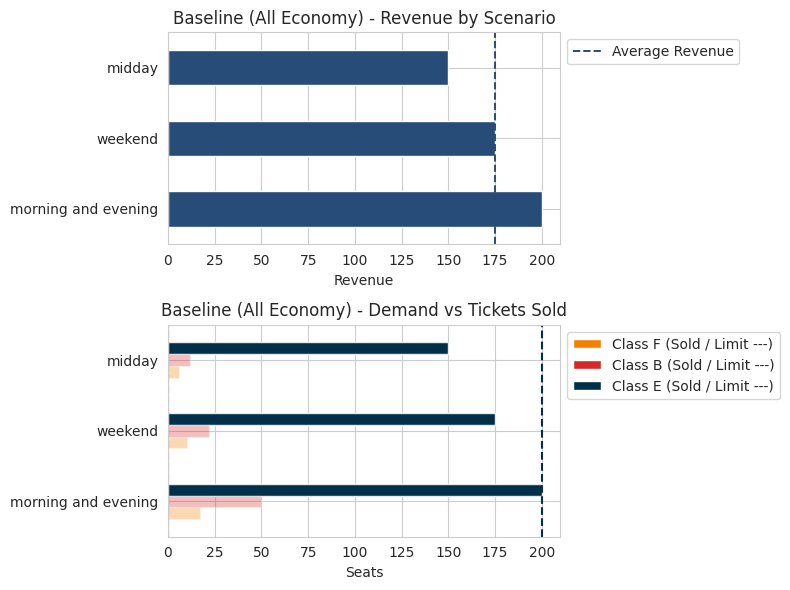

In [24]:
# Baseline solution (all seats in economy)
seats_all_economy = pd.Series({"F": 0, "B": 0, "E": 200})
generate_report(seats_all_economy, demand, seat_factor, revenue_factor, name="Baseline (All Economy)")


# Optimal Solution: Accounting for Uncertainty

To move beyond the baseline, we must account for the fact that demand is never a fixed number. We considered two primary frameworks for decision-making under uncertainty:

1. **Robust Optimization (The "Safe" Approach)**

    Robust optimization defines an uncertainty set (a range of possible outcomes) and seeks a solution that performs best under the worst-case scenario.

    - **Strengths**: Ideal for new routes with no historical data or periods of extreme volatility. It prioritizes "reliable" scheduling and risk-aversion, ensuring the airline remains viable even in a worst-case realization.

    - **Weaknesses**: It tends to be overly conservative. By optimizing for the worst case, the airline may leave high-value seats empty that could have been sold, effectively "leaving money on the table" during normal operations.

2. **Stochastic Optimization (The "Data-Driven" Approach)**

    Stochastic optimization uses historical data to define a probability distribution (e.g., Normal or Poisson) for demand. We want the solution to perform best on average and/or to meet certain probability guarantees.

    - **Strengths**: Leverages the decades of historical booking data available to airlines. By "playing the odds," this approach maximizes long-term profitability in standard operating environments.

    - **Weaknesses**: It is vulnerable to "Black Swan" events—unexpected crises like pandemics or fuel shocks—where historical patterns and probability distributions no longer hold true.


</br>

For this analysis, we have opted for **Stochastic Optimization** for the following reasons:

- **Data Maturity**: Airline demand typically follows well-established seasonal and historical patterns, making probability distributions highly reliable. In fact, we were given the demand estimates in the first table of this notebook.
- **Profit Maximization**: In a competitive market, maximizing the expected yield over hundreds of flights is more sustainable than preparing for a "worst-case" that rarely occurs.
- **Industry Standard**: Most Revenue Management systems (like those used for seat protection and overbooking) are built on stochastic foundations to balance the risk of "spoilage" (empty seats) against "spillage" (unmet demand).

</br>



---

</br>

Having established our "All-Economy" baseline, we now move toward finding the optimal seat configuration. Because airline demand is inherently uncertain, we will evaluate six distinct models. This progression allows us to transition from a simple "average" scenario to a sophisticated stochastic framework that accounts for risk, correlations, and loyalty program guarantees.

### Roadmap of Analytical Models

| Model | Focus | Approach |
| :--- | :--- | :--- |
| **Model 1** | Deterministic Baseline | Optimizes for the average demand scenario (Expectation of the Expected Value). |
| **Model 2** | Two-Stage Stochastic | Uses discrete scenarios to maximize average revenue over multiple outcomes. |
| **Model 3** | Analytical Chance Constraints | Adds probabilistic guarantees for loyalty members using independent normal distributions. |
| **Model 4** | Sample Average Approximation (SAA) | Addresses continuous demand by sampling $N$ independent scenarios. |
| **Model 5** | Correlated Demand | Incorporates multivariate normal distributions to model class dependencies. |
| **Model 6** | Integrated SAA & Chance Constraints | Uses Big-M binary variables to enforce service levels under correlated demand. |


</br>

## Model 1. Deterministic solution for the average demand scenario

A common starting point is to solve the deterministic problem where future demands are fixed at their mean values ($\mu_c$). This is known as the **Expectation of the Expected Value (EEV)** problem.


</br>


### Mathematical Formulation

Let $C$ be the set of classes $C = \{F, B, E\}$. We define:
* $s_c$: Number of seats of class $c$ installed in the aircraft.
* $t_c$: Number of tickets of class $c$ sold.
* $r_c$: Revenue per ticket for class $c$.
* $f_c$: Space factor (economy-equivalent displacement).

</br>

**Objective:**

The objective function is to maximize ticket revenue:

$$\max_{s_c, t_c} \quad \sum_{c \in C} r_c t_c$$

**Constraints:**
1. **Aircraft Capacity:** The total physical space cannot exceed 200 economy-equivalent seats.
   $$\sum_{c \in C} f_c s_c \leq 200$$
2. **Physical Limit:** Tickets sold cannot exceed installed seats.
   $$t_c \leq s_c \qquad \forall c \in C$$
3. **Demand Limit:** Tickets sold cannot exceed mean demand.
   $$t_c \leq \mu_c \qquad \forall c \in C$$
4. **Integrity:** All variables must be non-negative integers.
   $$\boldsymbol{t}, \boldsymbol{s} \in \mathbb{Z}_+$$

</br>

The following cell presents a Pyomo implementation of this model:

,F,B,E,Total
Seat Allocation,11.00,28.00,136.00,175.00
Economy Equivalent Allocation,22.00,42.00,136.00,200.00


,F,B,E
morning and evening,11.00,28.00,136.00
weekend,10.00,22.00,136.00
midday,6.00,12.00,136.00


,F,B,E
morning and evening,0.00,0.00,0.00
weekend,1.00,6.00,0.00
midday,5.00,16.00,0.00


,F,B,E
morning and evening,6.00,22.00,64.00
weekend,0.00,0.00,39.00
midday,0.00,0.00,14.00






Deterministic Model EEV - Expected Revenue (in units of economy ticket price): 204.33







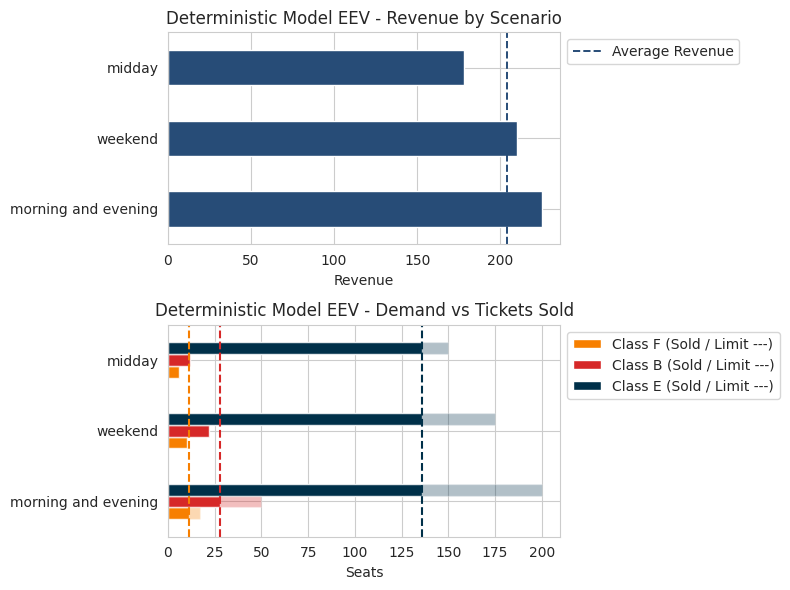

In [25]:
def average_demand(demand):
    m = pyo.ConcreteModel("Aircraft seat allocation - Average demand")

    m.CLASSES = pyo.Set(initialize=demand.columns)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def demand_limits(m, c):
        return m.tickets[c] <= demand[c].mean()

    @m.Constraint(m.CLASSES)
    def seat_limits(m, c):
        return m.tickets[c] <= m.seats[c]

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(m.tickets[c] * revenue_factor[c] for c in m.CLASSES)

    return m


# Solve deterministic model to obtain the expectation of the expected value problem (EEV)
model_eev = average_demand(demand)
SOLVER.solve(model_eev)
seats_eev = pd.Series({c: model_eev.seats[c]() for c in model_eev.CLASSES})
generate_report(seats_eev, demand, seat_factor, revenue_factor, name="Deterministic Model EEV")


The baseline all-economy setup provides a benchmark revenue of 175.00 units. Optimizing for the average demand scenario (EEV) successfully pushed this figure to 204.33 units—a significant 16.7% improvement. While this is a substantial gain, the deterministic model is "blind" to the risks of demand fluctuations. Can we capture even more revenue by explicitly modeling uncertainty? In the next step, we move beyond averages to see if a two-stage stochastic model can provide a more robust and profitable allocation.

## Model 2. Two-Stage Stochastic Optimization (Extensive Form)

In reality, seat allocation must be decided **before** demand is known (Stage 1), while tickets are sold **after** demand is realized (Stage 2). This structure is best captured by a **Two-Stage Stochastic Programming** framework.


</br>


### 1. General Framework (Compact Form)
The standard mathematical representation of a two-stage problem is:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & \boldsymbol{c}^\top \boldsymbol{x} + \mathbb{E} [Q(\boldsymbol{x}, \boldsymbol{z})] \\
\text{s.t.} \quad & A \boldsymbol{x} \leq \boldsymbol{b} \\
& \boldsymbol{x} \in \mathbb{R}^{n_x}
\end{aligned}
$$

Where the **second-stage value function** $Q(\boldsymbol{x}, \boldsymbol{z})$ represents the "recourse" or the optimal response to a specific realization of uncertainty $\boldsymbol{z}$:

$$
\begin{aligned}
Q(\boldsymbol{x}, \boldsymbol{z}) = \min_{\boldsymbol{y}} \quad & \boldsymbol{q}(\boldsymbol{z})^\top \boldsymbol{y} \\
\text{s.t.} \quad & R(\boldsymbol{z}) \boldsymbol{x} + S(\boldsymbol{z}) \boldsymbol{y} \leq \boldsymbol{t}(\boldsymbol{z}) \\
& \boldsymbol{y} \in \mathbb{R}^{n_y}
\end{aligned}
$$


</br>


### 2. The Extensive Form
Since most solvers cannot evaluate an abstract "expectation" directly, we use the **Extensive Form**. This is a deterministic equivalent where we discretize uncertainty into a finite set of $N$ scenarios ($S = \{1, \dots, N\}$), each with a probability $p_s$.

By **cloning** the second-stage variables for every scenario, we transform the stochastic model into a single, large-scale optimization problem.

#### Key Concepts:
* **Non-Anticipativity:** The first-stage variable $s_c$ does not vary by scenario. You must commit to one seat layout without knowing which future will unfold.
* **Coupling Constraints:** These link the stages, ensuring that in any given scenario, you cannot sell more tickets than the physical capacity installed in Stage 1.
* **Dimensionality:** The problem size scales with $N$. If we have 1,000 scenarios, the model will contain 1,000 sets of ticket-sale constraints.


</br>


### 3. Application to Seat Allocation
In our model, the seat counts ($s_c$) are the "here-and-now" decisions, while the tickets sold ($t_{c,s}$) are the scenario-dependent recourse actions.

A **scenario**, here, represents a possible realization of demand. Since the aircraft configuration is permanent ("bolted down"), it must perform efficiently across varying demand profiles. For this model, we discretize the infinite possibilities of demand into **three equiprobable scenarios** ($p_s = 1/3$) that represent the primary "travel modes" of the route:

1.  **Weekday Peaks:** High-volume business travel (High demand for First/Business).
2.  **Weekends:** Leisure-dominated travel (Moderate, balanced demand).
3.  **Weekday Midday:** Off-peak travel (Low demand across all classes).

By solving for these three scenarios simultaneously, the model finds a seat allocation that balances the risk of **spoilage** (empty seats during off-peak) against the risk of **spillage** (lost high-value sales during peaks).


#### First-Stage Problem:
We choose the seat allocation to maximize expected total revenue:
$$
\begin{aligned}
    \max \quad & \mathbb E_{z} [Q(\boldsymbol{s}, \boldsymbol{z})] \\
    \text{s.t.} \quad & \sum_{c\in C} f_c s_c \leq 200\\
    & \boldsymbol{s} \in \mathbb{Z}_+
\end{aligned}
$$

#### Second-Stage Problem (Recourse):
For a realized demand $\boldsymbol{z}$, we maximize ticket sales within the bounds of our chosen capacity:
$$
\begin{aligned}
    Q(\boldsymbol{s}, \boldsymbol{z}) := \max \quad & \sum_{c\in C} r_c t_{c}\\
    \text{s.t.} \quad
    & t_c \leq s_c & \forall \, c\in C \\
    & t_c \leq z_c & \forall \, c\in C \\
    & \boldsymbol{t} \in \mathbb{Z}_+
\end{aligned}
$$

#### Full Extensive Form (Implementation):
Assuming $N$ equally likely scenarios ($p_s = 1/N$), we solve the following integrated model:

$$
\begin{aligned}
\max_{s_c, t_{c,s}} \quad & \frac{1}{N} \sum_{s \in S} \sum_{c \in C} r_c t_{c, s} \\
\text{s.t.} \quad & \sum_{c \in C} f_c s_c \leq 200 \\
& t_{c,s} \leq s_c & \forall \, c\in C, \ \forall \, s \in S \\
& t_{c,s} \leq z_{c, s} & \forall \, (c, s) \in C \times S \\
& \boldsymbol{s}, \boldsymbol{t} \in \mathbb{Z}_+
\end{aligned}
$$



The following cell implements this Extensive Form in Pyomo, solving it for $N=3$ initial equiprobable scenarios.

,F,B,E,Total
Seat Allocation,10.00,20.00,150.00,180.00
Economy Equivalent Allocation,20.00,30.00,150.00,200.00


,F,B,E
morning and evening,10.00,20.00,150.00
weekend,10.00,20.00,150.00
midday,6.00,12.00,150.00


,F,B,E
morning and evening,0.00,0.00,0.00
weekend,0.00,0.00,0.00
midday,4.00,8.00,0.00


,F,B,E
morning and evening,7.00,30.00,50.00
weekend,0.00,2.00,25.00
midday,0.00,0.00,0.00






Two-Stage Stocastic Model - Expected Revenue (in units of economy ticket price): 210.67







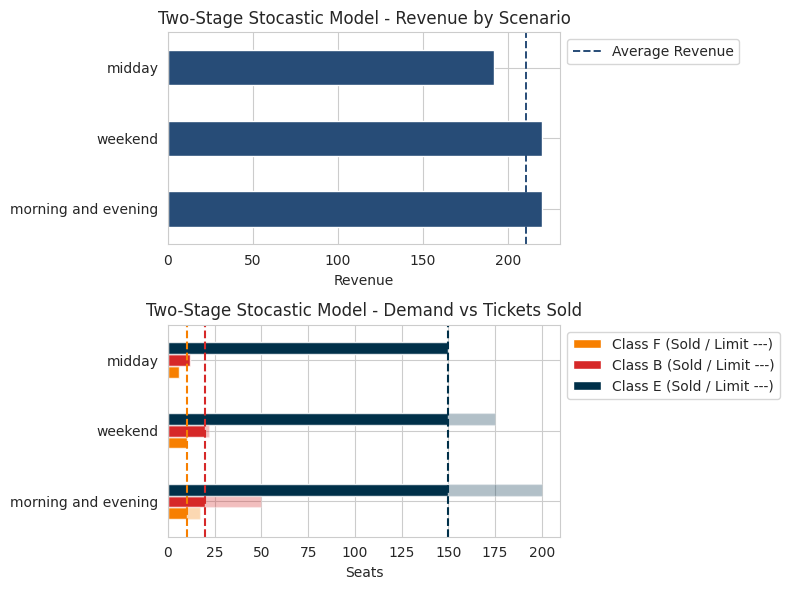

In [26]:
def aircraft_stochastic(demand):
    m = pyo.ConcreteModel("Aircraft seat allocation - Extensive form for demand scenarios")

    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limits(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limits(m, c, s):
        return m.tickets[c, s] <= m.seats[c]

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(
            m.tickets[c, s] * revenue_factor[c] for c in m.CLASSES for s in m.SCENARIOS
        )

    return m


# create and solve model for the three scenarios defined above
model_stochastic = aircraft_stochastic(demand)
SOLVER.solve(model_stochastic)
seats_stochastic = pd.Series(
    {c: model_stochastic.seats[c]() for c in model_stochastic.CLASSES}
)
generate_report(seats_stochastic, demand, seat_factor, revenue_factor, name="Two-Stage Stocastic Model")

Our transition from a deterministic approach to a two-stage stochastic framework has successfully unlocked additional value. While the EEV (Expected Value of the Mean) model improved upon the baseline by optimizing for average demand, it remained "blind" to the revenue opportunities during high-demand peaks.


By explicitly modeling uncertainty through the Extensive Form, our Two-Stage Stochastic Model achieved an expected revenue of 210.67 units. The difference between this result and the EEV (204.33) is 6.34 units, a metric known as the **Value of the Stochastic Solution (VSS)**. This VSS represents the tangible profit gained by choosing a seat allocation that hedges against multiple scenarios simultaneously, effectively reducing "spillage" during busy periods without over-committing resources during off-peak times.

## Model 3. Impact Assessment: Loyalty Commitments vs. Revenue Recovery


As Azul navigates its financial restructuring and bankruptcy proceedings, every seat on the São Paulo-Rio route must be treated as a critical asset. Currently, the airline maintains a loyalty program that guarantees high availability for its most frequent flyers. While these "Service Level Guarantees" are vital for long-term customer retention, they impose physical constraints on seat allocation that may conflict with immediate revenue maximization.

> We reiterate that this information is completely fictional and does not reflect Azul's actual operations and/or business policy.

In this model, we incorporate these existing commitments as **Chance Constraints** to quantify their impact on our optimal configuration and total expected revenue.

### 1. The Loyalty Program "Service Level" Mandate
To maintain the value proposition of the loyalty program, the airline's current policy requires:
* **First Class Protection:** A **98% probability** of covering all demand from First-class loyalty members ($z_F$).
* **Business Class Protection:** A **95% probability** of covering Business-class loyalty demand ($z_B$).

**The Upgrade Provision:** Business-class passengers are considered "covered" if they can secure a Business seat ($s_B$) *or* are upgraded to an available First-class seat ($s_F$). Consequently, our second constraint applies to the **combined capacity** of both premium cabins.

### 2. Demand Distribution and Parameters
We model the demand from these high-priority members using a **Normal Distribution**, i.e., $z_F \sim \mathcal N(\mu_F, \sigma_F^2)$ and $z_B \sim \mathcal N(\mu_B, \sigma_B^2)$. This allows us to account for the volatility in booking patterns while restructuring:

<center>

| Class | $\mu$ (Mean) | $\sigma$ (Std Dev) |
| :--: | :--: | :--: |
| **First (F)** | 11 | 4 |
| **Business (B)** | 28 | 8 |
| **Economy (E)** | 175 | 20 |

</center>

*Note: For this initial assessment, we assume demands are independent across classes and scenarios.*

### 3. Transforming Guarantees into Linear Constraints
To assess these impacts within our optimization framework, we transform the probabilistic mandates into **Linear Deterministic Equivalents**. This allows us to see the "floor" these policies set for our seat counts.


1.  **First Class Floor:**
    $$\frac{s_F - \mu_F}{\sigma_F} \geq \Phi^{-1}(0.98) \approx 2.054 \implies s_F \geq \mu_F + 2.054\sigma_F$$

2.  **Combined Premium Floor:**
    Since $z_F$ and $z_B$ are independent, their sum is normally distributed with mean $\mu_F + \mu_B$ and variance $\sigma_F^2 + \sigma_B^2$:
    $$\frac{(s_F + s_B) - (\mu_F + \mu_B)}{\sqrt{\sigma_F^2 + \sigma_B^2}} \geq \Phi^{-1}(0.95) \approx 1.645$$

Here, $\Phi^{-1}$ represents the Inverse Cumulative Distribution Function (CDF) of the Standard Normal Distribution (a.k.a. Quantile Function or z-score).

By adding these constraints, we can determine the **opportunity cost** of the loyalty program: how much revenue is Azul "sacrificing" to ensure its best customers remain loyal during the bankruptcy process?


,F,B,E,Total
Seat Allocation,20.00,34.00,109.00,163.00
Economy Equivalent Allocation,40.00,51.00,109.00,200.00


,F,B,E
morning and evening,17.00,34.00,109.00
weekend,10.00,22.00,109.00
midday,6.00,12.00,109.00


,F,B,E
morning and evening,3.00,0.00,0.00
weekend,10.00,12.00,0.00
midday,14.00,22.00,0.00


,F,B,E
morning and evening,0.00,16.00,91.00
weekend,0.00,0.00,66.00
midday,0.00,0.00,41.00






Chance Constraints Model - Expected Revenue (in units of economy ticket price): 187.33







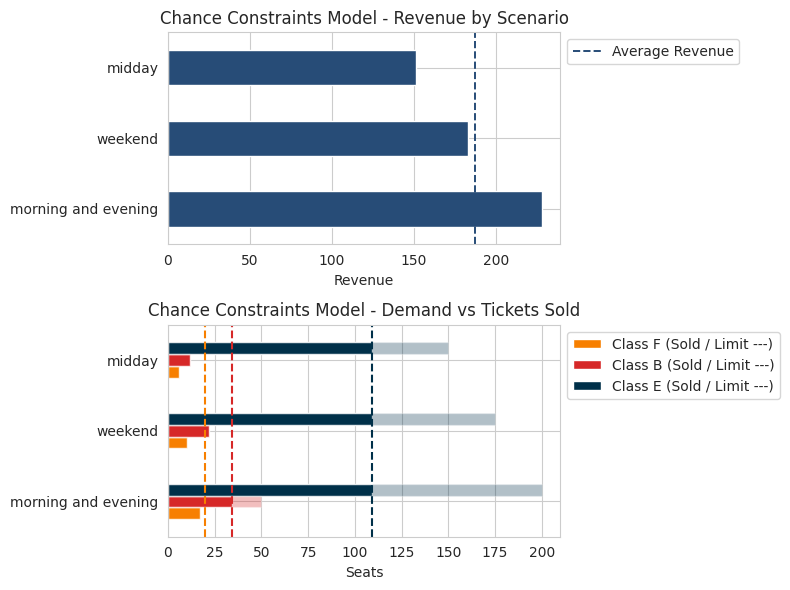

In [27]:
# define the mean and standard deviation of the demand for each class
mu = demand.mean()
sigma = {"F": 4, "B": 8, "E": 20}


def aircraft_cc(demand, QoSF=0.98, QoSFB=0.95):
    # create two-stage stochastic model as before
    m = aircraft_stochastic(demand)

    # add equivalent counterparts of the two chance constraints to the first stage problem
    # the coefficients related the inverse CDF of the standard normal are computed using the norm.ppf function
    @m.Constraint()
    def first_class(m):
        return (m.seats["F"] - mu["F"]) >= norm.ppf(QoSF) * sigma["F"]

    @m.Constraint()
    def business_class(m):
        return m.seats["F"] + m.seats["B"] - (mu["F"] + mu["B"]) >= norm.ppf(
            QoSFB
        ) * np.sqrt(sigma["F"] ** 2 + sigma["B"] ** 2)

    return m


# create and solve model
model_cc = aircraft_cc(demand)
SOLVER.solve(model_cc)
seats_cc = pd.Series({c: model_cc.seats[c]() for c in model_cc.CLASSES})
generate_report(seats_cc, demand, seat_factor, revenue_factor, name="Chance Constraints Model")

The results for Model 3 are stark: incorporating the current loyalty program's service level guarantees drops the expected revenue to 187.00 units. This is erasing significant financial gains achieved through optimization in previous models. The rigid "floor" created by these 98% and 95% service mandates forces the aircraft into a configuration that is heavily weighted toward premium cabins that may remain empty during off-peak scenarios. From a management perspective, this identifies the loyalty program in its current form as a massive opportunity cost, potentially hindering the airline's ability to generate the cash flow necessary for a successful recovery.

### Sensitivity Analysis: The Shadow Price of Loyalty

In optimization, the Shadow Price (Dual Value) represents how much our objective function (Total Revenue) would improve if we relaxed a specific constraint by one unit. In the context of Azul's restructuring, these values quantify the exact trade-off between keeping a promise to loyalty members and generating the cash flow needed for survival.

By inspecting the dual values for our Chance Constraints, we can identify the "bottlenecks" in our aircraft configuration:

- Shadow Price of first class: This value tells us how many units of revenue we lose for every additional First-Class seat we are forced to install to meet the 98% service level.
- Shadow Price of business class: This indicates the revenue impact of the 95% combined premium guarantee.


The drop in revenue from 210.67 (Stochastic) to 176.00 (Chance Constraints) indicates that these dual values are likely very high.

- **Identifying Inefficiencies**: If the shadow price for the 98% First-Class guarantee is significantly higher than that of Business Class, it suggests that the First-Class mandate is disproportionately damaging the airline's recovery.
- **Policy Renegotiation**: In a bankruptcy scenario, these shadow prices provide data-driven evidence for management to renegotiate loyalty terms. For example, if a shadow price is -5.0, it means reducing the "safety buffer" by just one seat would allow the airline to generate 5 units of economy-equivalent revenue—a 5:1 leverage that is hard to ignore during liquidation risks.
- **The "Cost of Protection"**: High shadow prices prove that the airline is "paying" a high premium to keep its most frequent flyers happy. While retention is important, these duals show exactly how much that retention is costing the creditors.


</br>

Our original models used **Integer Variables** because seat counts must be whole numbers. However, dual values are a property of continuous optimization. To find them, we use **Linear Relaxation**, which allows for fractional seats during calculation. This "smooths out" the problem, allowing the solver to calculate the "pressure" or "slope" of our constraints.

In [9]:
# 1. Create the model instance
model_cc = aircraft_cc(demand)

# 2. Relax integrality: converts all NonNegativeIntegers to NonNegativeReals
pyo.TransformationFactory('core.relax_integer_vars').apply_to(model_cc)

# 3. Define the Suffix for duals
model_cc.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# 4. Solve the relaxed model
results = SOLVER.solve(model_cc)

# 5. Extract the Shadow Prices
# Note: Since we are MAXIMIZING, a negative dual means the constraint
# is "costing" us revenue by pushing us away from the unconstrained peak.
sp_first_class = model_cc.dual.get(model_cc.first_class, 0)
sp_business_class = model_cc.dual.get(model_cc.business_class, 0)

print(f"Shadow Price - First Class Guarantee: {sp_first_class:.2f}")
print(f"Shadow Price - Combined Premium Guarantee: {sp_business_class:.2f}")

Shadow Price - First Class Guarantee: -3.50
Shadow Price - Combined Premium Guarantee: -2.50


The solver has returned the following marginal values for our constraints:

- First Class Guarantee (98%): -3.50
- Combined Premium Guarantee (95%): -2.50

A shadow price of -3.50 means that for every single seat the loyalty program forces us to add to the First Class cabin, Azul loses 3.50 units of expected revenue.

Because a First-Class seat ($s_F$) takes up the space of 2.0 Economy seats ($f_F=2$), this shadow price indicates that the "cost" of the constraint is much higher than just the physical space it occupies. This means that the loyalty requirement is not only making Azul lose Economy space but it is also forcing the company into a sub-optimal balance across all three scenarios (Weekday, Weekend, and Midday).

The shadow price of -2.50 for the combined Business and First Class guarantee shows that the "floor" for total premium capacity is also actively suppressing revenue. While less "expensive" than the First-Class specific mandate, it still represents a significant penalty for maintaining a 95% service level.

</br>

#### Strategic Conclusion for the Restructuring:

If management were to relax the First-Class service level just enough to reduce the requirement by 4 seats, the expected revenue would increase by approximately 14 units (-4 $\times$ -3.50).

In a bankruptcy scenario, these results suggest that the 98% First Class guarantee is the primary "bottleneck" to profitability. To recover financially, Azul may need to consider lowering these service levels to a more sustainable "Expected Value" approach, or significantly increasing the price of loyalty-program tickets to offset these high opportunity costs.


</br>

To find a true path to recovery, we cannot look at First Class in isolation. We must analyze how both mandates—First and Business—interact to suppress revenue. In the following cell, we use a Grid Search Heatmap to visualize the entire revenue surface, allowing us to identify the specific policy coordinates that will allow Azul to move back toward solvency. It allows us to see the exact **efficient frontier** of how much revenue we trade away for every percentage point of customer satisfaction we guarantee.


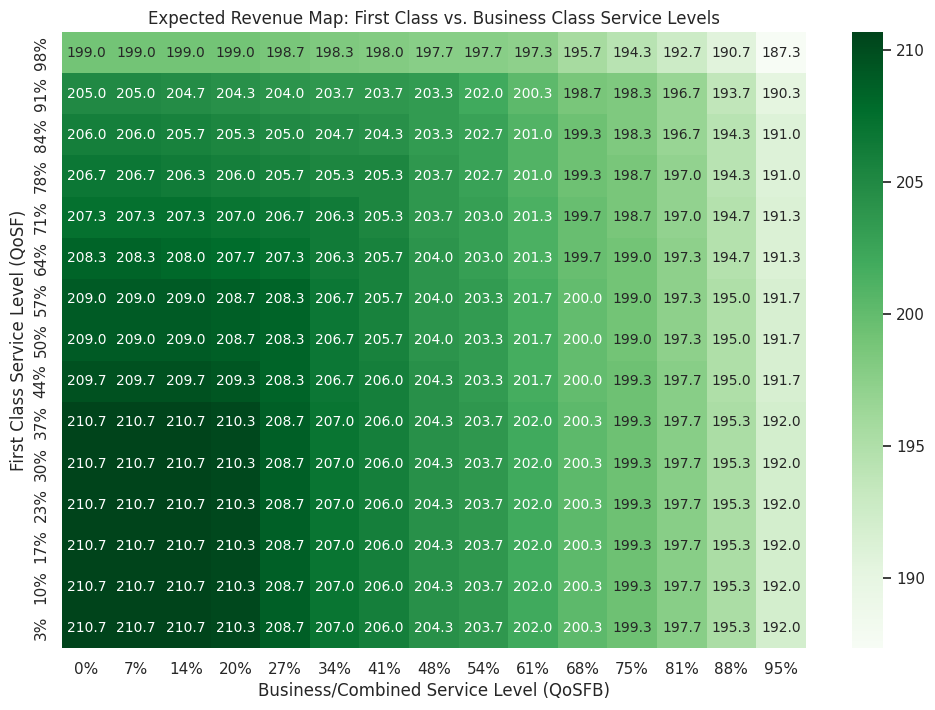

In [78]:
# 1. Define the grid for First Class and Business Class service levels
grid_size = 15
qos_f_range = np.linspace(0.03, 0.98, grid_size)
qos_fb_range = np.linspace(0.00, 0.95, grid_size)

# 2. Matrix to store revenue results
revenue_matrix = np.zeros((grid_size, grid_size))

# 3. Systematic Sweep (Grid Search)
for i, f_val in enumerate(qos_f_range):
    for j, fb_val in enumerate(qos_fb_range):
        m_map = aircraft_cc(demand, QoSF=f_val, QoSFB=fb_val)
        SOLVER.solve(m_map)
        # Store average revenue per flight
        revenue_matrix[i, j] = pyo.value(m_map.revenue) / len(demand.index)

# 4. Plotting the 2D Expected Revenue Heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    revenue_matrix,
    annot=True,
    fmt=".1f",
    annot_kws={"size": 10},
    xticklabels=[f"{x*100:.0f}%" for x in qos_fb_range],
    yticklabels=[f"{y*100:.0f}%" for y in qos_f_range],
    cmap="Greens"
)
ax.invert_yaxis()
plt.title("Expected Revenue Map: First Class vs. Business Class Service Levels")
plt.xlabel("Business/Combined Service Level (QoSFB)")
plt.ylabel("First Class Service Level (QoSF)")
plt.show()

The current Loyalty Program corresponds to the top-right corner in this map. We observe that just relaxing the First-Class Service Level (moving down the y-axis), the expected revenue would plateau at 192.0 units. This indicates that we need to consider both mandates for an effective restructuring of the company.

## Model 4. Sample Average Approximation (SAA)

While our previous Chance Constraint (CC) model allowed us to incorporate risk and service levels, it remains a static, analytical shortcut. The CC approach collapses the entire probability distribution into a single "safety buffer" (e.g., "I need at least 54 seats to be 95% sure").

The primary limitation is that **it does not simulate the actual selling of tickets**. It ensures the seats are physically on the plane, but it cannot calculate the nuance of "spoilage" (seats that sit empty in low-demand scenarios) or "spillage" (revenue lost in high-demand scenarios). It provides a configuration based on a threshold, but it cannot accurately predict the actual cash flow resulting from that configuration.

</br>

### Modeling a Continuous Reality

In the real world, every flight is different. Demand is not a set of three scenarios (Weekday, Weekend, and Midday), but a **continuous spectrum of possibilities**. To capture this, we now model demand as a random vector $(z_F, z_B, z_E)$, where each class follows a Normal Distribution $\mathcal N(\mu_c, \sigma_c^2)$.

Unlike the CC case, which only looks at a specific tail of the distribution, this approach looks at the **entire distribution**. This allows us to account for the interplay between classes—specifically, how a surge in one class might "steal" space from another. Furthermore, modeling demand as a vector allows us to incorporate **correlation effects**, reflecting how demand for different cabins often moves together due to seasonal or economic factors (e.g., a major tech conference in Rio).


<center>

| Class | $\mu$ (Mean) | $\sigma$ (Std Dev) |
| :--: | :--: | :--: |
| **First (F)** | 11 | 4 |
| **Business (B)** | 28 | 8 |
| **Economy (E)** | 175 | 20 |

</center>


</br>


### The SAA Methodology

To solve this problem with a continuous demand spectrum, we use the **Sample Average Approximation (SAA)** method. Since we cannot mathematically solve for an infinite number of scenarios, SAA approximates the "true" expected value through simulation:
- **Sampling**: We draw $N$ independent realizations (scenarios) ($z_{F,s}, z_{B,s}, z_{E,s}$) from the demand distributions.
- **Discretization**: Since ticket demand must be a whole number, we round the sampled continuous values down to the nearest non-negative integer.
- **Optimization**: We solve the deterministic extensive form of the problem using these $N$ samples, essentially forcing the model to find a single seat configuration that performs best **on average** across all $N$ potential futures. Here, we treat each as an equally likely scenario with probability $1/N$.

In this step, we use a **Monte Carlo approximation**, assigning an equal probability $(p_s = 1/N)$ to each scenario. This assumption ensures that as $N$ increases, the sample average of our objective function converges to the true expected revenue. Crucially, this equiprobability holds regardless of whether the demands are correlated or independent, as the structural relationships between classes are captured within the sampled values themselves.

</br>

To begin our analysis, we will first consider an **uncorrelated scenario**. By assuming class demands are independent, we can establish a **performance baseline**. This will allow us to see how the SAA configuration differs from the 3-scenario stochastic and CC models before we introduce the added complexity of a correlated demand structure. To make our simulation robust, we incorporate a **Correlation Matrix** $\boldsymbol{\rho}$. This allows us to generate scenarios where class demands move together, providing a more realistic "stress test" for the aircraft's capacity limits.


### Scenario generation (uncorrelated case)

,F,B,E
F,16,0,0
B,0,64,0
E,0,0,400


,Target Mean,Sample Mean,Mean Error %,Target Std,Sample Std,Std Error %
F,11.00,10.84,1.43,4.00,4.04,1.07
B,28.00,27.75,0.89,8.00,7.99,0.10
E,175.00,174.84,0.09,20.00,20.31,1.53


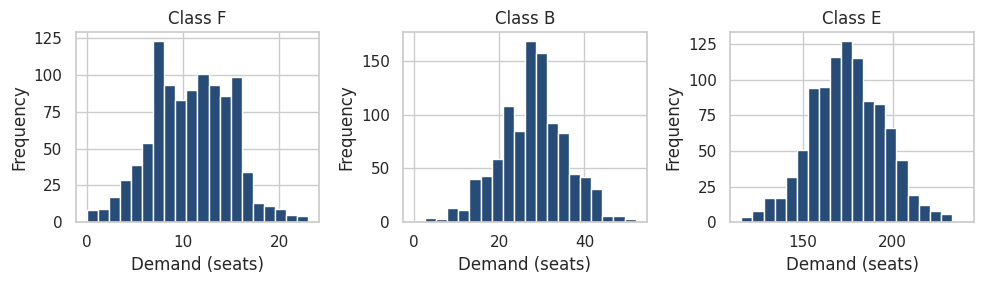

In [79]:
# Sample size
N = 1000

classes = demand.columns

# Build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ np.diag(s)
df = pd.DataFrame(S, index=classes, columns=classes)
display(df.style.set_caption("Covariance Matrix"))

print("\n\n")

# Generate N samples, round each demand entry to nearest integer
seed = 42
rng = np.random.default_rng(seed)
samples = rng.multivariate_normal(list(mu), S, N).round()
demand_saa = pd.DataFrame(samples, columns=classes)
demand_saa[demand_saa < 0] = 0  # clip negative values

# Report sample means and standard deviations for each class in a
# consolidated comparison table
comparison_df = pd.DataFrame({
    "Target Mean": mu,
    "Sample Mean": demand_saa.mean(),
    "Mean Error %": np.abs((demand_saa.mean() - mu) / mu) * 100,
    "Target Std": pd.Series(sigma),
    "Sample Std": demand_saa.std(),
    "Std Error %": np.abs((demand_saa.std() - pd.Series(sigma)) / pd.Series(sigma)) * 100
}).round(2)
display(comparison_df.style
        .format("{:.2f}")
        .background_gradient(subset=['Mean Error %', 'Std Error %'], cmap='Reds')
        .set_caption("SAA Sampling Validation: Target Parameters vs. Generated Samples"))

print("\n\n")

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, ci in enumerate(classes):
    demand_saa[ci].hist(ax=ax[i], bins=20, color="#274c77")
    ax[i].set_title(f"Class {ci}")
    ax[i].set_xlabel("Demand (seats)")
    ax[i].set_ylabel("Frequency")
fig.tight_layout()

In the next cell we introduce a new function to report the solution along with some statistical analysis for this more general continuous demand structure.

In [88]:
def seat_report_saa(seats, demand):
    """Function to report analytics for SAA case"""

    classes = seats.index
    N = len(demand)

    # 1. Seat Allocation Summary
    equivalent_seats = pd.DataFrame({
        "Seats": seats,
        "Factor": pd.Series(seat_factor),
        "Eq. Econ. Seats": seats * pd.Series(seat_factor)
    })
    display(equivalent_seats.T.style
            .format(precision=1)
            .set_caption("Cabin Configuration"))

    # 2. Performance Metrics Calculation
    tickets = pd.DataFrame({c: np.minimum(seats[c], demand[c]) for c in classes})
    unsold = pd.DataFrame({c: seats[c] - tickets[c] for c in classes})
    spillage = demand - tickets
    revenue = tickets.dot(revenue_factor) # Total revenue per scenario

    # Calculate actual revenue densitty: (Tickets Sold * Price) / Floor Space
    # This shows the actual "cash flow" generated per square meter.
    total_space = (seats * pd.Series(seat_factor)).sum()
    actual_revenue_density = pd.DataFrame({
        c: (tickets[c] * revenue_factor[c]) / (seats[c] * seat_factor[c])
        for c in classes
    })

    # Plane-wide average density for benchmarking
    avg_plane_density = revenue / total_space

    # Calculate Financial Density Margin:
    # ((Demand - Capacity) * Ticket Price) / Seat Factor
    # This measures the 'Profitability per Square Meter' of floor space.
    # Positive = Revenue Spillage (Space under-supplied -- Money we failed to collect)
    # Negative = Revenue Spoilage (Space over-supplied -- Value of the 'air' we flew)
    financial_margin = pd.DataFrame({
        c: (demand[c] - seats[c]) * revenue_factor[c] / seat_factor[c] for c in classes
    })

    # Consolidated Statistics Table
    load_factors = (tickets / seats.replace(0, np.nan)).fillna(0)
    stats_df = pd.DataFrame({
        "Mean Demand": demand.mean(),
        "Mean Sold": tickets.mean(),
        "Mean Unsold": unsold.mean(),
        "Avg Load Factor": load_factors.mean() * 100
    }).round(2)
    print("\n\n")
    display(stats_df.style.format("{:.2f}").set_caption(f"Operational Metrics (N={N})"))

    print("\n\n")


    # --------------------

    # 4. REVENUE VISUALIZATIONS
    sns.set_style("whitegrid")
    fig, (ax_rev, ax_rev_d) = plt.subplots(1, 2, figsize=(8, 4))

    # Revenue per class (the Revenue Driver)

    # Calculate Total Revenue per class per scenario
    class_revenue = pd.DataFrame({
        c: tickets[c] * revenue_factor[c] for c in classes
    })

    # Calculate Space Share for the legend/annotations
    space_per_class = seats * pd.Series(seat_factor)
    total_space = space_per_class.sum()
    space_share = (space_per_class / total_space) * 100

    # Plot Total Revenue Distribution (ignore outliers to keep the plot clean)
    sns.boxplot(data=class_revenue, palette=COLORS, ax=ax_rev, showfliers=False)

    # Add Mean Revenue Labels and Space Share Annotations
    # Dynamic Annotation Placement
    ymin, ymax = ax_rev.get_ylim()
    y_range = ymax - ymin
    buffer = 0.05 * y_range        # Distance from boxplot whiskers/outliers
    line_spacing = 0.07 * y_range  # Gap between the two lines of text
    threshold = ymax - (0.20 * y_range) # Threshold to flip to bottom

    means = class_revenue.mean()
    for i, (c, m) in enumerate(means.items()):
        # Identify the extremes (excluding outliers)
        q1 = class_revenue[c].quantile(0.25)
        q3 = class_revenue[c].quantile(0.75)
        iqr = q3 - q1
        upper_whisker_bound = q3 + 1.5 * iqr
        lower_whisker_bound = q1 - 1.5 * iqr
        data_max = class_revenue[c][class_revenue[c] <= upper_whisker_bound].max()
        data_min = class_revenue[c][class_revenue[c] >= lower_whisker_bound].min()

        # 2. Determine Group Position (Top or Bottom)
        if data_max > threshold:
            # Place below: Space is at the bottom, Mean is line_spacing above it
            base_y = data_min - buffer - 2 * line_spacing
            v_align = 'top'
        else:
            # Place above: Space is on top of data, Mean is line_spacing above Space
            base_y = data_max + buffer
            v_align = 'bottom'

        # 3. Draw the "Mean" label (Always the higher one in the pair)
        ax_rev.text(i, base_y + line_spacing, f"Avg: {m:.1f}",
                    ha='center', va='bottom', fontweight='bold', color='white', fontsize=9,
                    bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

        # 4. Draw the "Space Share" label (Always the lower one in the pair)
        ax_rev.text(i, base_y, f"Space: {space_share[c]:.1f}%",
                    ha='center', va='bottom', fontsize=10,
                    color='blue', fontweight='bold')

    ax_rev.set_title("Total Revenue Contribution)", fontsize=14)
    ax_rev.set_ylabel("Total Revenue (Units)")
    ax_rev.set_xlabel("Cabin Class")

    # Revenue density per class (most valuable class)

    # Calculate Theoretical Max Density (Price / Factor)
    max_density = pd.Series({c: revenue_factor[c] / seat_factor[c] for c in classes})

    # Create a comparative bar for the "Ceiling"
    sns.barplot(x=max_density.index, y=max_density.values,
                color='gray', alpha=0.2, ax=ax_rev_d, label='Theoretical Max (100% Full)')

    # Overlay the actual performance (Boxplot shows the distribution across scenarios)
    sns.boxplot(data=actual_revenue_density, palette=COLORS, ax=ax_rev_d,
                showfliers=False, width=0.5)
    means = actual_revenue_density.mean()
    for i, m in enumerate(means):
        ax_rev_d.plot(i, m, 'wo', markersize=8, markeredgecolor='black', label='Mean Revenue Density' if i == 0 else "")

    # Add Plane Average Benchmark
    ax_rev_d.axhline(avg_plane_density.mean(), color="red", linestyle='--', label="Plane Average")

    ax_rev_d.set_title("Revenue Driver: Realized vs. Potential Yield", fontsize=14)
    ax_rev_d.set_ylabel("Revenue Units / Sqm")
    ax_rev_d.set_xlabel("Cabin Class")
    ax_rev_d.legend(loc="lower right", fontsize="small")

    plt.tight_layout()
    plt.show()


    print("\n\n")
    # --------------------

    # 5. Scenarios Visualizations
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 3)

    # Revenue Distribution
    ax_rev = fig.add_subplot(gs[0, 0:2])
    sns.histplot(revenue, kde=True, color='green', ax=ax_rev)
    ax_rev.axvline(revenue.mean(), color='red', linestyle='--', label=f'Mean: {revenue.mean():.1f}')
    ax_rev.set_title(f"Total Expected Revenue Distribution")
    ax_rev.set_xlabel("Revenue (units)")
    ax_rev.legend()

    # Distribution of financial risk/opportunity (Top Row, Right)
    ax_fin = fig.add_subplot(gs[0, 2])
    sns.boxplot(data=financial_margin, palette=COLORS, ax=ax_fin, showfliers=False)
    ax_fin.axhline(0, color='black', linewidth=1.5, linestyle='-')
    ymin, ymax = ax_fin.get_ylim()
    ax_fin.fill_between([-0.5, 2.5], 0, ymax, color='green', alpha=0.1, label='Density Spillage (Lost Revenue/sqm)')
    ax_fin.fill_between([-0.5, 2.5], ymin, 0, color='red', alpha=0.1, label='Density Spoilage (Wasted Revenue/sqm)')
    ax_fin.set_title("Floor Space Productivity Gap \n (Revenue Units per Economy-Equivalent Space)", fontsize=14)
    ax_fin.set_ylabel("Revenue Density Gap")
    ax_fin.set_xlabel("Cabin Class")
    # Add mean markers
    means = financial_margin.mean()
    for i, m in enumerate(means):
        ax_fin.plot(i, m, 'wo', markersize=8, markeredgecolor='black', label='Net Mean Density Gap' if i == 0 else "")
    ax_fin.legend()


    # Capacity Margin Plots (Bottom Row - No changes here)
    for i, c in enumerate(classes):
        ax = fig.add_subplot(gs[1, i])
        margin = demand[c] - seats[c]
        sns.histplot(margin, ax=ax, color='teal', alpha=0.6, discrete=True)
        ax.axvline(0, color='red', linestyle='-')
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.fill_between([0, xmax], ymin, ymax, color='green', alpha=0.1)
        ax.fill_between([xmin, 0], ymin, ymax, color='red', alpha=0.1)
        ax.set_title(f"Class {c}: Capacity Margin")
        at_capacity_pct = (demand[c] >= seats[c]).mean() * 100
        ax.text(0.05, 0.9, f"Sold Out: {at_capacity_pct:.1f}%", transform=ax.transAxes, fontweight='bold', color='red')

    plt.tight_layout()
    plt.show()


We can now solve the stochastic optimization problem using the generated $N=1000$ scenarios by calling the previously defined function `aircraft_stochastic`. Notice that we are **ignoring the loyalty program** from Model 3, so we are **not** including the chance constraints for now.

,F,B,E
Seats,10.0,24.0,144.0
Factor,2.0,1.5,1.0
Eq. Econ. Seats,20.0,36.0,144.0


,Mean Demand,Mean Sold,Mean Unsold,Avg Load Factor
F,10.84,8.75,1.25,87.54
B,27.75,22.34,1.66,93.10
E,174.84,143.41,0.59,99.59


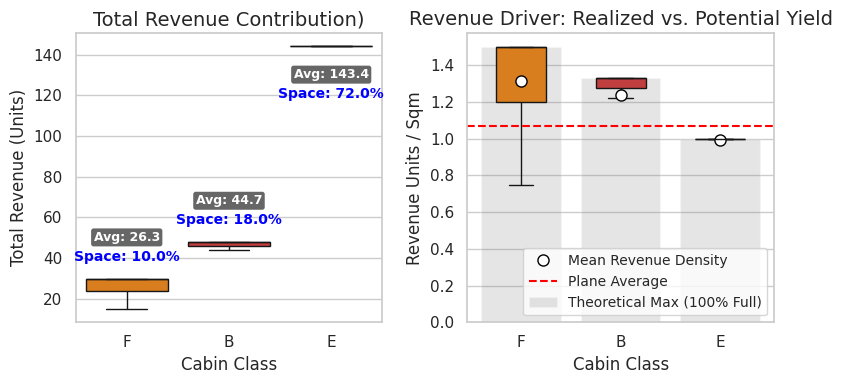

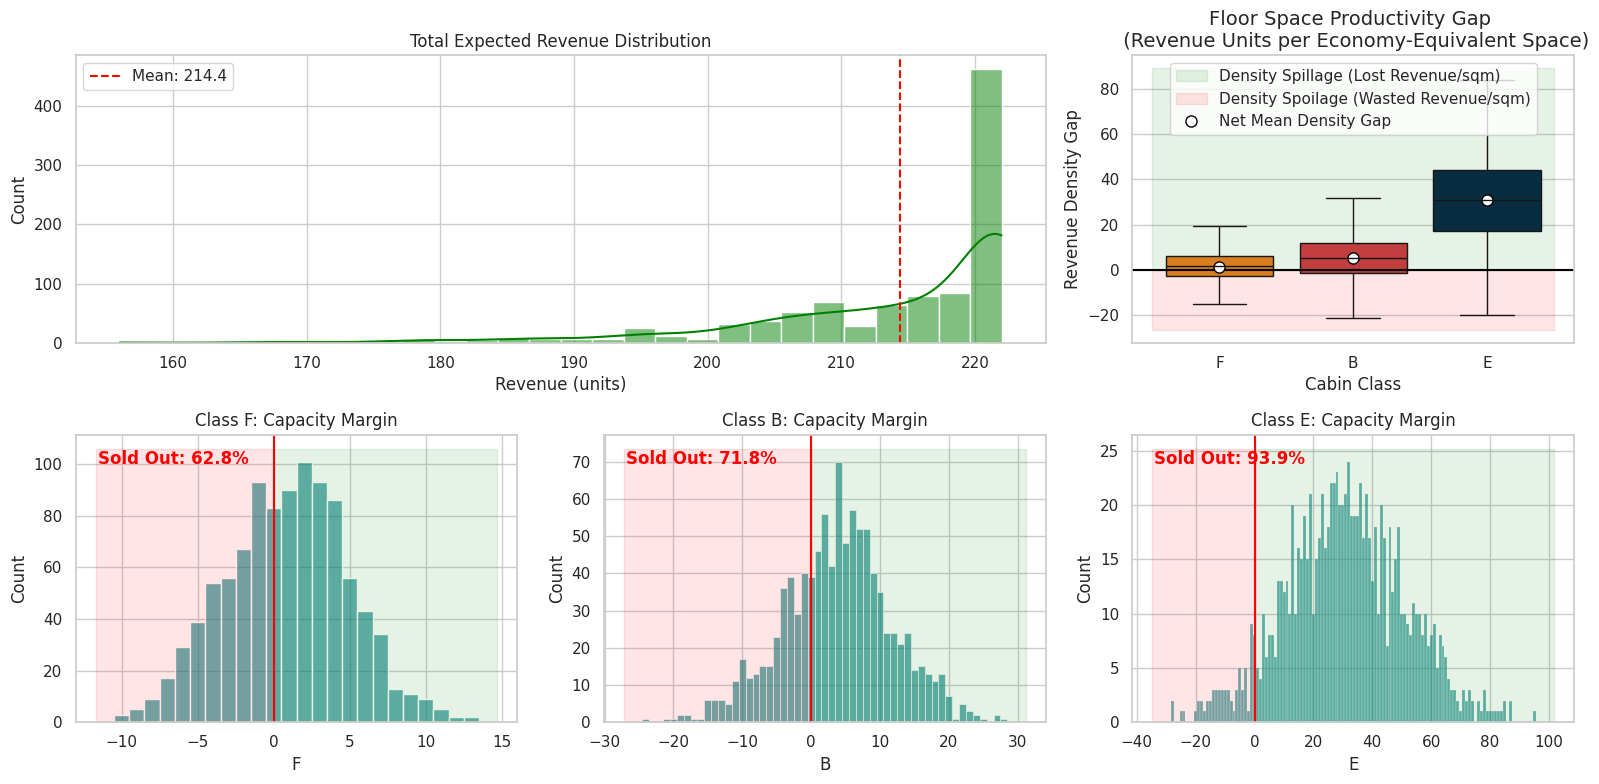

In [89]:
model_saa = aircraft_stochastic(demand_saa)
SOLVER.solve(model_saa)
seats_saa = pd.Series({c: model_saa.seats[c]() for c in model_saa.CLASSES})
seat_report_saa(seats_saa, demand_saa)

This dashboard provides a comprehensive look at how our aircraft configuration handles the uncertainty of real-world demand. By simulating 1,000 different "flight days", we move beyond simple averages to see the financial and operational risks of our chosen cabin layout.

### 1. Revenue Performance & Portfolio Mix
The **Total Expected Revenue Distribution** visualizes the total revenue generated across our simulated scenarios. The mean of **214.4 units** represents our "expected" daily performance. The distribution is heavily right-skewed, with a significant concentration of flights hitting the upper revenue ceiling. This indicates a configuration that is highly optimized to capture maximum value during peak demand, though it remains vulnerable to a "left tail" of lower-revenue days.

To understand what drives this revenue, we look at the **Total Revenue Contribution**:
* **Economy (E):** The "Cash Cow," providing an average of **143.4 units**. It occupies **72.0%** of the cabin floor, showing a very stable, low-variance revenue stream.
* **Premium (B & F):** These classes provide the "top-up" revenue. While their individual contributions are smaller (**44.7** and **26.3 units** respectively), they occupy a disproportionately small amount of space (**18.0%** and **10.0%**), making them essential for reaching high total revenue targets.

### 2. Revenue Drivers: The Efficiency Test
The **Realized vs. Potential Yield** chart compares the actual money earned per square meter against the **Theoretical Max** (the gray bars).
* **Efficiency Capture:** Economy is perfectly efficient; its realized density matches its potential because it is almost always sold out.
* **The Premium Gap:** First (F) and Business (B) classes have much higher *potential* density (taller gray bars), but their *realized* density (the boxplots) is lower. Business Class, in particular, consistently outperforms the **Plane Average** (red dashed line), while First Class shows higher volatility, often dipping below the plane's average productivity per square meter.

### 3. Floor Space Productivity: The "Gap" Diagnostic
The **Floor Space Productivity Gap** is our most critical diagnostic for cabin efficiency. To compare different classes fairly, we normalize all metrics by their **"Footprint"**—the actual physical floor area a seat occupies relative to a standard Economy seat (the `seat_factor`). This allows us to evaluate the aircraft's earning power on an "apples-to-apples" basis: revenue per square meter.

The **"Gap"** represents the financial mismatch between the demand we received and the capacity we provided:
* **Positive Gap (Green Zone / Spillage):** Demand exceeded capacity ($\text{Demand} > \text{Seats}$). This is **"Lost Revenue Density"**—the money left on the table because the cabin was too small to satisfy everyone who wanted to buy a ticket.
* **Negative Gap (Red Zone / Spoilage):** Capacity exceeded demand ($\text{Seats} > \text{Demand}$). This is **"Wasted Revenue Density"**—the value of the "empty air" flown because the cabin was too large for the actual demand.

In a perfect world, every class would sit at **0 (Perfect Balance)**, meaning we provided exactly the right amount of space for the demand. However, in reality, we are working with a **finite, fixed total floor area**, and the classes have vastly different "earning power" (Revenue Density). Because the total space is limited, the solver must make a choice: every square meter given to one class must be taken from another. This leads to a deliberate, calculated imbalance:

Because the total space is limited, the solver must make a choice: every square meter given to one class must be taken from another. This leads to a deliberate, calculated imbalance:

* **The High-Value Protection (Premium Classes):** First and Business classes have much higher revenue density. The "cost" of missing a single high-value passenger is extremely high. Therefore, the solver is willing to accept some **Spoilage (Negative Gap)** in these cabins. It effectively "over-supplies" them with space to ensure that whenever a high-paying passenger shows up, a seat is available.
* **The Economy "Sacrifice":** Economy has the lowest revenue density. Because space is a zero-sum game, the solver "starves" Economy of floor area to make room for the more profitable premium seats. The resulting **high positive gap (Spillage)** isn't a mistake—it’s a sign of efficiency. The solver has determined that the revenue gained from satisfying that extra Economy demand is lower than the revenue protected by giving that same space to a Premium cabin.

In summary, the gaps are not zero because the solver has found the **optimal asymmetric balance**: it accepts "wasted" space in premium cabins and "lost" customers in Economy to ensure the total revenue of the entire aircraft is as high as possible.


### 4. Operational Robustness: Capacity Margins
The bottom row of **Capacity Margin** plots shows the physical mismatch between supply and demand. These charts center on the **Capacity Limit (0)**.
* **Premium Classes (F & B):** Balanced with Sold Out rates of **62.8%** and **71.8%**. This is the "Service Level Sweet Spot"—it ensures that on most days, a high-value traveler can find a seat, maintaining the brand's premium promise.
* **Economy (E):** With a **93.9% Sold Out rate**, the distribution is shifted almost entirely into the **Spillage (Green)** zone. This confirms Economy's role as the aircraft's "filler" class. It is kept intentionally small to ensure near-100% utilization, effectively sacrificing its own lost demand to protect the high-margin availability in premium cabins.

</br>

**Strategic Outlook**

These results demonstrate a high level of efficiency for a profit-maximizing configuration under the assumption of **uncorrelated demand**. In reality, airline demand is highly interdependent; external factors like holidays or economic shifts often cause demand to move in tandem across all cabins. To enhance the realism of our simulation, we will first incorporate these correlations to observe how interdependencies shift the optimal balance (Model 5). Finally, we will conclude our study by reintroducing the constraints of the Fidelity Program (Model 6) to reconcile profit maximization with strategic loyalty obligations.

## Model 5: Accounting for Demand Correlation

In previous iterations, we treated the demand for First, Business, and Economy classes as independent variables. In reality, airline demand is rarely isolated; external factors such as seasonality, economic shifts, or specific events typically cause demands across different cabins to move in tandem. To capture this behavior, we transition from independent sampling to a **Multivariate Normal Distribution** defined by a **Correlation Matrix ($\boldsymbol{\rho}$)**.

### Mathematical Formulation

We model the ticket demand for the three categories as a 3-dimensional random vector $D \sim \mathcal{N}(\mu, \Sigma)$, where $\mu$ represents the mean demand and $\Sigma$ is the covariance matrix. The relationship between classes is defined by the symmetric correlation matrix:

$$
\boldsymbol{\rho} = \begin{pmatrix}
1 & \rho_{FB} & \rho_{FE} \\
\rho_{BF} & 1 & \rho_{BE} \\
\rho_{EF} & \rho_{EB} & 1
\end{pmatrix}
$$

The covariance matrix $\Sigma$ is constructed using the standard deviations of each class ($\sigma_c$) and the correlation matrix $P$ as follows: $\Sigma = \text{diag}(\sigma) \, \boldsymbol{\rho} \, \text{diag}(\sigma)$. Expanded, this gives:

$$
\Sigma = \begin{pmatrix}
\sigma_F^2 & \rho_{FB}\sigma_F\sigma_B & \rho_{FE}\sigma_F\sigma_E \\
\rho_{BF}\sigma_B\sigma_F & \sigma_B^2 & \rho_{BE}\sigma_B\sigma_E \\
\rho_{EF}\sigma_E\sigma_F & \rho_{EB}\sigma_E\sigma_B & \sigma_E^2
\end{pmatrix}
$$

### Parameter Selection and Simulation

For this analysis, we assume positive correlations between all classes, reflecting the tendency for general travel demand to rise and fall together:
* **Strong correlation** between First and Business ($\rho_{FB} = 0.6$).
* **Moderate correlation** between Business and Economy ($\rho_{BE} = 0.4$).
* **Weak correlation** between First and Economy ($\rho_{FE} = 0.2$).

We will sample $N=1000$ scenarios from this correlated distribution. By applying the **Sample Average Approximation (SAA)** method, we can observe how these interdependencies shift the optimal cabin configuration compared to the uncorrelated model.

,Target Mean,Sample Mean,Mean Error %,Target Std,Sample Std,Std Error %
F,11.00,11.09,0.80,4.00,3.95,1.32
B,28.00,28.14,0.51,8.00,7.76,2.96
E,175.00,177.06,1.18,20.00,19.84,0.82


,F,B,E
F,16.00,19.20,16.00
B,19.20,64.00,64.00
E,16.00,64.00,400.00


,F,B,E
F,15.58,17.20,14.98
B,17.20,60.26,62.18
E,14.98,62.18,393.47


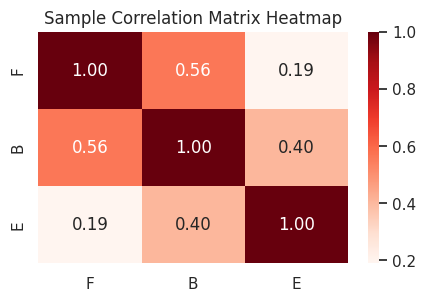

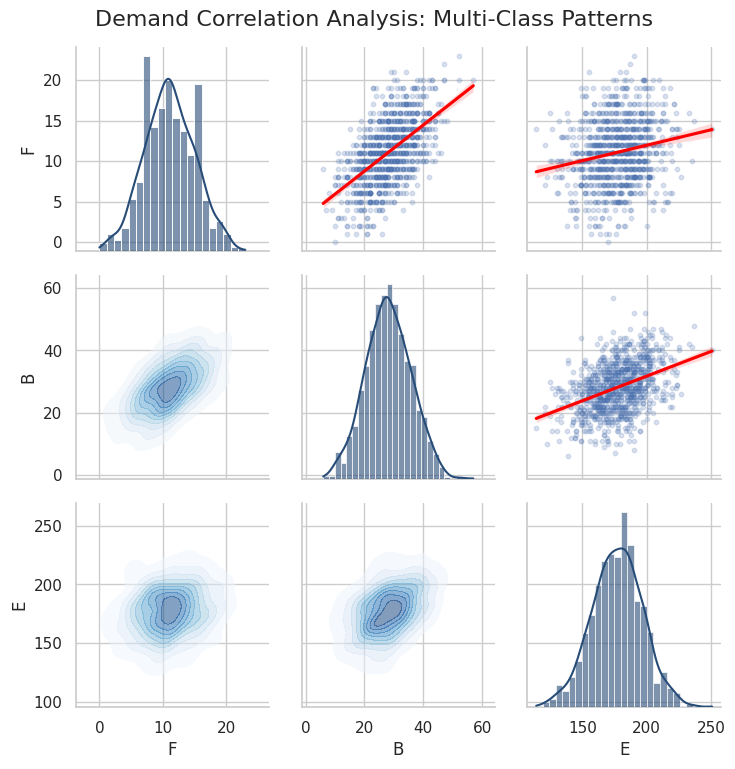

In [90]:
# sample size
N = 1000

# correlation matrix
rho = np.array([[1, 0.6, 0.2], [0.6, 1, 0.4], [0.2, 0.4, 1]])

# build covariance matrix from covariances and correlations
s = np.array(list(sigma.values()))
S = np.diag(s) @ rho @ np.diag(s)

# generate N samples, round each demand entry to nearest integer
seed = 0
rng = np.random.default_rng(seed)
samples = rng.multivariate_normal(list(mu), S, N).round()
demand_saa_corr = pd.DataFrame(samples, columns=classes)
demand_saa_corr[demand_saa_corr < 0] = 0  # Only positive values are allowed

# Report sample means and standard deviations for each class in a
# consolidated comparison table
comparison_df = pd.DataFrame({
    "Target Mean": mu,
    "Sample Mean": demand_saa_corr.mean(),
    "Mean Error %": np.abs((demand_saa_corr.mean() - mu) / mu) * 100,
    "Target Std": pd.Series(sigma),
    "Sample Std": demand_saa_corr.std(),
    "Std Error %": np.abs((demand_saa_corr.std() - pd.Series(sigma)) / pd.Series(sigma)) * 100
}).round(2)
display(comparison_df.style
        .format("{:.2f}")
        .background_gradient(subset=['Mean Error %', 'Std Error %'], cmap='Reds')
        .set_caption("SAA Sampling Validation: Target Parameters vs. Generated Samples"))


print("\n\n")
df = pd.DataFrame(S, index=classes, columns=classes)
display(df.style
        .format("{:.2f}")
        .set_caption("Model Covariance"))

print("\n\n")
display(pd.DataFrame(demand_saa_corr.cov()).style
        .format("{:.2f}")
        .set_caption("Sample Covariance"))

print("\n\n")

plt.figure(figsize=(5, 3))
sns.heatmap(demand_saa_corr.corr(), annot=True, cmap="Reds", fmt=".2f")
plt.title("Sample Correlation Matrix Heatmap")
plt.show()

sns.set_theme(style="whitegrid")
g = sns.PairGrid(demand_saa_corr, diag_sharey=False, corner=False)
g.map_diag(sns.histplot, kde=True, color="#274c77", alpha=0.6)
g.map_upper(sns.regplot, scatter_kws={'alpha':0.2, 's':10}, line_kws={'color':'red'})
g.map_lower(sns.kdeplot, cmap="Blues", fill=True, alpha=0.5)
g.fig.suptitle("Demand Correlation Analysis: Multi-Class Patterns", y=1.02, fontsize=16)
plt.show()

,F,B,E
Seats,10.0,24.0,144.0
Factor,2.0,1.5,1.0
Eq. Econ. Seats,20.0,36.0,144.0


,Mean Demand,Mean Sold,Mean Unsold,Avg Load Factor
F,11.09,8.92,1.08,89.22
B,28.14,22.56,1.44,94.00
E,177.06,143.55,0.45,99.69


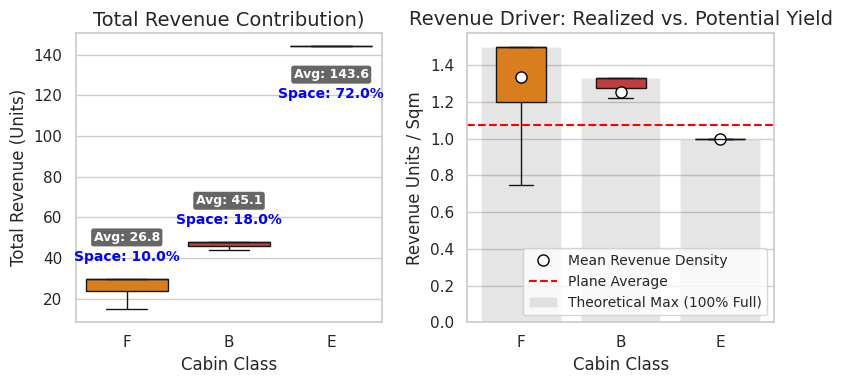

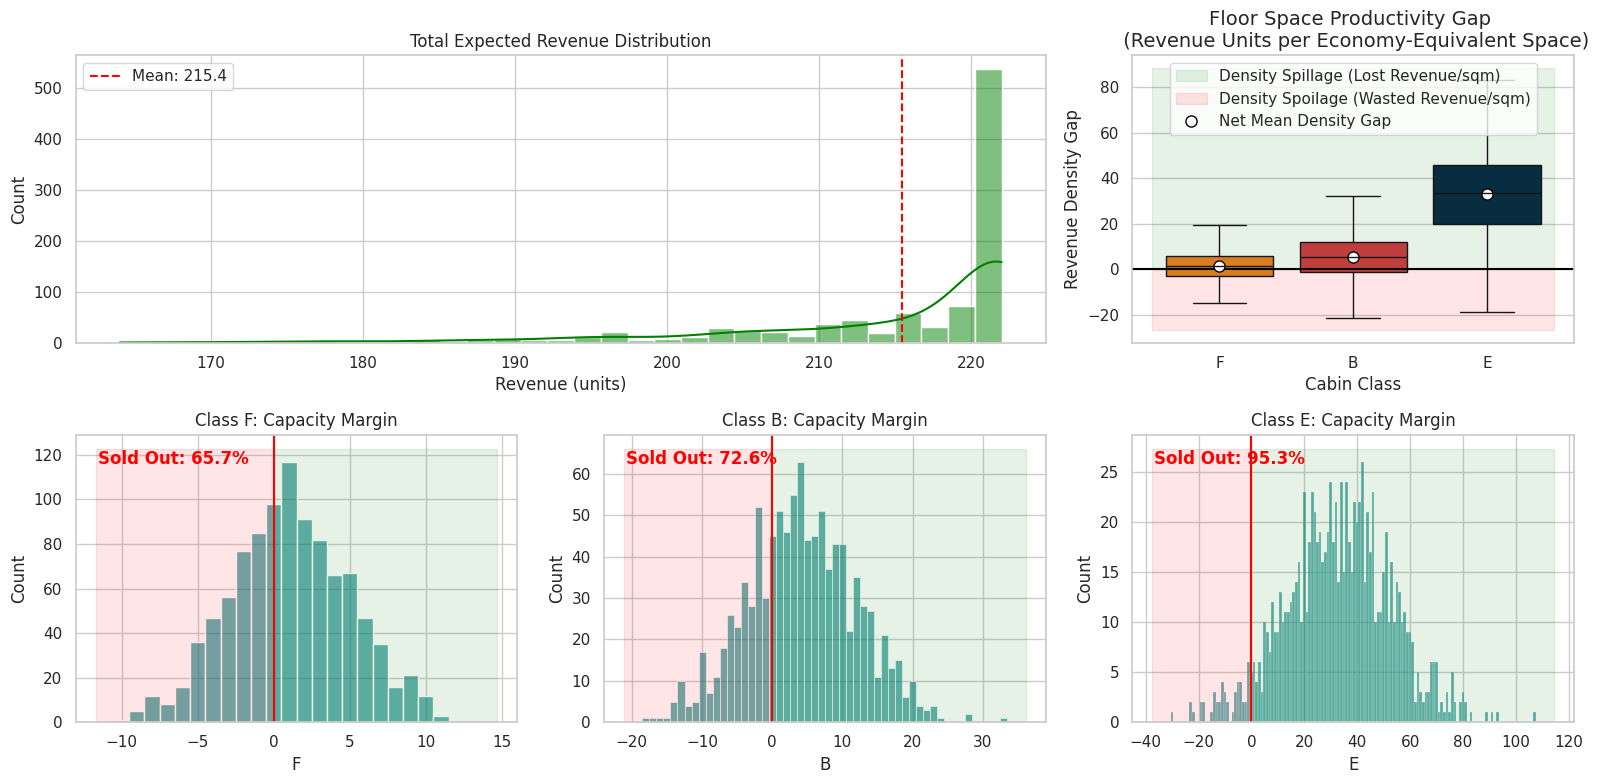

In [91]:
model_saa = aircraft_stochastic(demand_saa_corr)
SOLVER.solve(model_saa)
seats_saa = pd.Series({c: model_saa.seats[c]() for c in model_saa.CLASSES})
seat_report_saa(seats_saa, demand_saa_corr)

## Model 6: SAA with Empirical Chance Constraints (Correlated Case)

In Model 3, we relied on **Linear Analytic Equivalents** to satisfy our loyalty program mandates. While efficient, those formulas require a strict assumption of independence between cabin demands. Because we have now introduced correlation, the math behind those shortcuts is no longer valid. To address this, Model 6 shifts from a theoretical formula to an **empirical counting** method using the **Sample Average Approximation (SAA)**.

### The Challenge: Correlation and Joint Risks
When cabin demands are correlated, the risk of a "stockout" in First Class and Business Class often happens simultaneously. We can no longer calculate these risks in isolation. Instead, we must look at our 1,000 simulated scenarios as a "historical record" and ensure our cabin configuration successfully handles the required percentage of them.

### Mathematical Reformulation: The Big-M Logic
We introduce binary "indicator" variables ($y_s, w_s$) that act as counters for each scenario $s$. If the demand in a scenario exceeds the seats we've provided, the model is forced to "flag" that scenario as a failure.

The reformulated constraints for the second stage are:

$$
\begin{align*}
    t_{c,s} & \leq s_c && \forall c \in C, s \in S \\
    t_{c,s} & \leq d_{c,s} && \forall c \in C, s \in S \\
    s_F + M y_s & \geq d_{F, s} && \forall s \in S \\
    (s_F + s_B) + M w_s & \geq (d_{F, s} + d_{B,s}) && \forall s \in S \\
    \frac{1}{N} \sum_{s\in S} y_s & \leq 0.02 && (\text{98% First Class Guarantee}) \\
    \frac{1}{N} \sum_{s\in S} w_s & \leq 0.05 && (\text{95% Business Class Guarantee})
\end{align*}
$$

### How to Interpret this Logic
* **The Big-M "Bypass":** The constant $M$ is a very large number. If the binary variable $y_s$ is 0, the constraint is active, forcing the seats ($s_F$) to be greater than demand ($d_{F,s}$). If $y_s$ is 1, the $M$ term makes the constraint "trivially true," effectively allowing the model to fail that scenario.
* **Counting Failures:** The final two constraints act as a **failure budget**. They tell the solver: *"You are allowed to fail the loyalty guarantee in at most 2% (or 5%) of the simulated scenarios. Choose the scenarios that are the most expensive to satisfy so we can maximize revenue in the rest."*
* **Data-Driven Decisions:** Unlike the previous models, this approach doesn't care about the underlying distribution shape. It looks directly at the 1,000 data points and finds the configuration that satisfies the loyalty rules with the highest possible profit.



> **Computational Note:** This model is a Mixed-Integer Linear Program (MILP), but it is significantly more complex than previous iterations. While earlier versions only featured a few integer variables for seats, this formulation adds thousands of binary "indicator" variables ($y_s, w_s$) to track loyalty failures across every scenario. This creates a combinatorial "Failure Budget" problem, forcing the solver to navigate a massive Branch-and-Bound search tree to decide exactly which specific scenarios to sacrifice to maximize total revenue. Because the solver must now evaluate millions of potential "either/or" combinations for these binary switches, expect significantly longer execution times as it mathematically proves the global optimum.
>
> **How "big" is the problem?** In a standard optimization, we might only have 3 variables (how many seats for each class: $s_F,s_B, s_E$). But because we are using SAA, the solver has to create "copies" of our operational variables for every single simulated flight day to ensure the constraints hold across the whole sample. So, for every one of our 1,000 scenarios, the solver has to calculate how many tickets were sold for each class (3 $\times$ 1,000 continuous variables), and the a binary "switches" to check if we met the service level for our two loyalty mandates (1,000 + 1,000 binary variables). This yields a total of 5,003 variables.
>
> A 5,000-variable problem is medium-sized. However, the search space is not the number of variables; it is the number of possible combinations of those variables. The most daunting part of our problem is the 2,000 binary variables, which makes up for astronomically $2^{(2 \times N)} = 2^{2000} \approx 10^{602}$ binary combinations!

,F,B,E
Seats,19.0,37.0,106.0
Factor,2.0,1.5,1.0
Eq. Econ. Seats,38.0,55.5,106.0


,Mean Demand,Mean Sold,Mean Unsold,Avg Load Factor
F,11.09,11.06,7.94,58.23
B,28.14,27.64,9.36,74.70
E,177.06,106.00,0.00,100.00


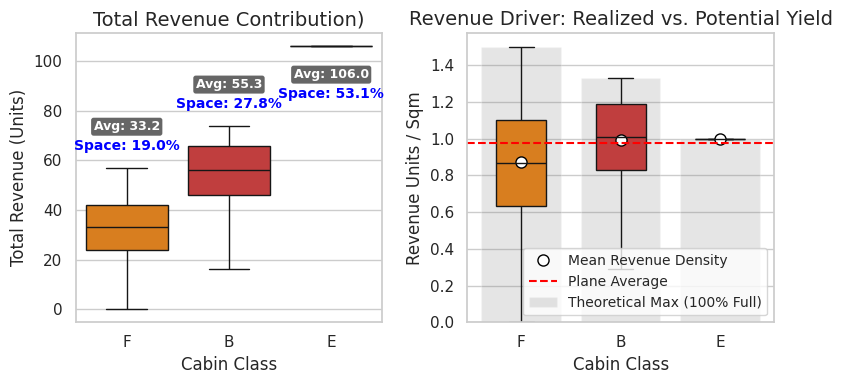

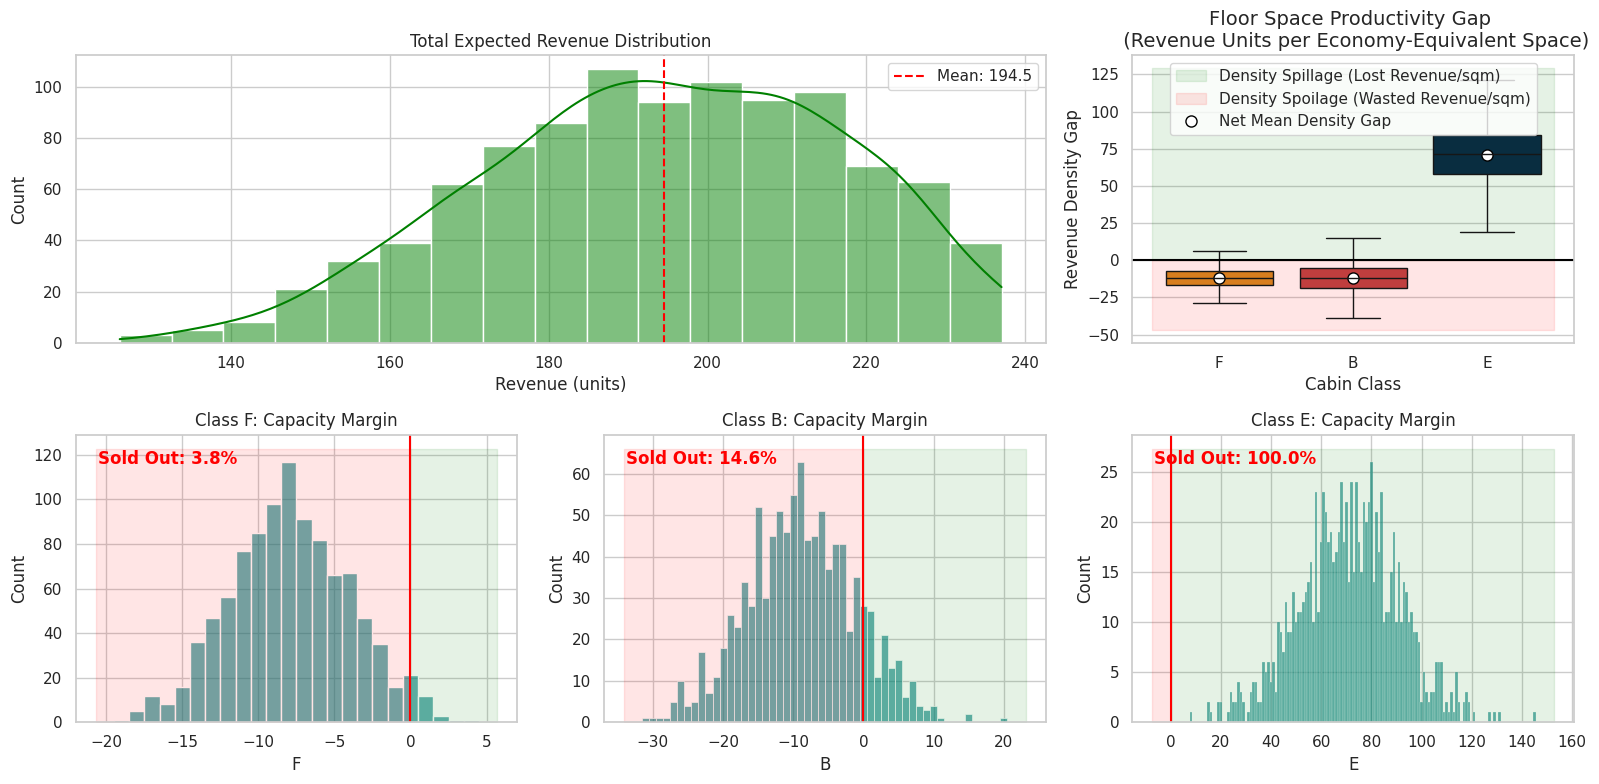

In [92]:
# define a "safe" big-M constant for chance constraints MILO counterparts
bigM = demand_saa_corr.max().max() * 2


def aircraft_final(demand):
    m = pyo.ConcreteModel("Aircraft seat allocation - Correlated demand")

    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # first stage variables and constraints
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint(m.CLASSES)
    def plane_seats(m, c):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # second stage variable and constraints
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeIntegers)
    m.first_class = pyo.Var(m.SCENARIOS, domain=pyo.Binary)
    m.business_class = pyo.Var(m.SCENARIOS, domain=pyo.Binary)

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limits(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limits(m, c, s):
        return m.tickets[c, s] <= m.seats[c]

    @m.Constraint(m.SCENARIOS)
    def first_class_loyality(m, s):
        return m.seats["F"] + bigM * m.first_class[s] >= demand["F"][s]

    @m.Constraint()
    def first_class_loyality_rate(m):
        return sum(m.first_class[s] for s in m.SCENARIOS) <= 0.02 * len(m.SCENARIOS)

    @m.Constraint(m.SCENARIOS)
    def business_class_loyality(m, s):
        return (
            m.seats["F"] + m.seats["B"] + bigM * m.business_class[s]
            >= demand["B"][s] + demand["F"][s]
        )

    @m.Constraint()
    def business_class_loyality_rate(m):
        return sum(m.business_class[s] for s in m.SCENARIOS) <= 0.05 * len(m.SCENARIOS)

    # objective
    @m.Objective(sense=pyo.maximize)
    def revenue(m):
        return sum(
            m.tickets[c, s] * revenue_factor[c] for c in m.CLASSES for s in m.SCENARIOS
        )

    return m


# create model
model = aircraft_final(demand_saa_corr)
SOLVER.solve(model)
seats = pd.Series({c: model.seats[c]() for c in model.CLASSES})
seat_report_saa(seats, demand_saa_corr)

The simulation results over 1000 scenarios reveal an Expected Mean Revenue of 194.5 units, with the distribution exhibiting a traditional bell curve that suggests a stable but risk-exposed revenue model. While the majority of outcomes cluster between 180 and 220 units, the "left tail" of the distribution shows that under specific correlated demand drops, revenue can fall significantly below the mean, highlighting the inherent volatility that remains even with optimized seat allocation.

The effectiveness of the loyalty program mandates is clearly visible in the capacity margin analysis for the premium cabins. First Class (F) shows a 3.8% Sold Out rate, meaning the airline successfully fulfills all demand in over 96% of cases, though this results in substantial Density Spoilage as evidenced by the large green "empty seats" region. Business Class (B) operates at a 14.6% Sold Out rate, indicating a more aggressive but still protective allocation strategy. These figures represent the empirical success of the Big-M constraints, which allow the solver to "budget" failures during peak correlated demand spikes to protect overall profitability.

Conversely, Economy Class (E) remains the primary driver of revenue density while suffering the highest opportunity cost. With a 100.0% Sold Out rate, Economy is permanently in a state of Spillage, where demand consistently exceeds supply. This is further supported by the Floor Space Productivity Gap chart, which shows that Economy Class produces a massive positive revenue density gap of approximately 75 units per sqm. In contrast, First and Business classes show negative gaps, confirming that the airline is effectively "subsidizing" the floor space of premium passengers to maintain loyalty guarantees. The model suggests that while the current configuration meets the strategic goals of the loyalty program, the airline is leaving significant potential revenue on the table by not capturing the excess demand in the Economy cabin.


</br>


Having established the baseline for **Model 6**, we will now perform a sensitivity test on the service level guarantees. While the loyalty program mandates specific seat availability for high-value passengers, these constraints inevitably impose a "tax" on total revenue. By systematically varying the required service levels (the "Sold Out" probability thresholds), we can observe how different levels of loyalty commitment force the model to reconfigure the aircraft. This analysis identifies the "tipping point" where the cost of maintaining premium service levels begins to significantly erode the flight's overall profitability.

> **Computational Note:** Performing this grid search imposes a significant computational burden because our MILO model must juggle 2,000 binary indicator variables across 1,000 distinct scenarios (see previous computational note). To manage this, we can select a specific **Relative Gap (MIP Gap)**—a parameter that defines the percentage difference between the "Best Found" solution and the theoretical mathematical "Bound" (the absolute best possible result if all constraints were relaxed). While a full search for the **perfect global optimum** can take **over 1 hour**, choosing a **1% gap** instructs the solver to stop as soon as it is within a negligible margin of that peak, cutting execution time to approximately **30 minutes**. This strategic trade-off allows for rapid iteration and decision-making for Azul's solvency without sacrificing the practical accuracy of the final cabin layout.

In [93]:
from tqdm.notebook import tqdm
import itertools

def aircraft_saa_parameterized(demand, alpha_f, alpha_fb):
    """
    Model 6 adapted for parameter sweep.
    alpha_f: Allowed failure rate for First Class (e.g., 0.02)
    alpha_fb: Allowed failure rate for Combined (e.g., 0.05)
    """
    m = pyo.ConcreteModel()
    m.CLASSES = pyo.Set(initialize=demand.columns)
    m.SCENARIOS = pyo.Set(initialize=demand.index)

    # First stage: Seats
    m.seats = pyo.Var(m.CLASSES, domain=pyo.NonNegativeIntegers)

    @m.Constraint()
    def plane_capacity(m):
        return sum(m.seats[c] * seat_factor[c] for c in m.CLASSES) <= capacity

    # Second stage: Tickets and Binary "Fail" Indicators
    # Optimization: Using NonNegativeReals for tickets to speed up the MILP
    m.tickets = pyo.Var(m.CLASSES, m.SCENARIOS, domain=pyo.NonNegativeReals)
    m.y_f = pyo.Var(m.SCENARIOS, domain=pyo.Binary)  # First Class Failures
    m.y_fb = pyo.Var(m.SCENARIOS, domain=pyo.Binary) # Combined Failures

    # Standard SAA Constraints
    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def demand_limit(m, c, s):
        return m.tickets[c, s] <= demand[c][s]

    @m.Constraint(m.CLASSES, m.SCENARIOS)
    def seat_limit(m, c, s):
        return m.tickets[c, s] <= m.seats[c]

    # Big-M Loyalty Constraints
    bigM = demand.max().max() * 2

    @m.Constraint(m.SCENARIOS)
    def first_class_guarantee(m, s):
        return m.seats["F"] + bigM * m.y_f[s] >= demand["F"][s]

    @m.Constraint(m.SCENARIOS)
    def combined_guarantee(m, s):
        return (m.seats["F"] + m.seats["B"] + bigM * m.y_fb[s]) >= (demand["F"][s] + demand["B"][s])

    # Chance Constraints (The "Failure Budget")
    @m.Constraint()
    def budget_f(m):
        return sum(m.y_f[s] for s in m.SCENARIOS) <= alpha_f * len(m.SCENARIOS)

    @m.Constraint()
    def budget_fb(m):
        return sum(m.y_fb[s] for s in m.SCENARIOS) <= alpha_fb * len(m.SCENARIOS)

    @m.Objective(sense=pyo.maximize)
    def obj(m):
        return sum(m.tickets[c, s] * revenue_factor[c] for c in m.CLASSES for s in m.SCENARIOS) / len(m.SCENARIOS)

    return m

SOLVER_GAP = pyo.SolverFactory('appsi_highs')
# Set a 1% relative gap (stops once within 1% of optimal)
#SOLVER_GAP.options['mip_rel_gap'] = 0.01
# Set a 30-second time limit per solve to prevent "hanging" on difficult cells
#SOLVER_GAP.options['time_limit'] = 30

# --- GRID SEARCH EXECUTION ---

grid_size = 10 # Reduced for performance;

# Service Level ranges
f_service_lvl_range = np.linspace(0.08, 0.98, grid_size)
fb_service_lvl_range = np.linspace(0.05, 0.95, grid_size)

# We use alpha (Failure Rate) which is 1 - Service Level
alpha_f_range = 1 - f_service_lvl_range
alpha_fb_range = 1 - fb_service_lvl_range

revenue_matrix = np.zeros((grid_size, grid_size))

grid_indices = list(itertools.product(range(grid_size), range(grid_size)))

print(f"Starting Sweep: {grid_size**2} MILP iterations...")
for i, j in tqdm(grid_indices, desc="Revenue Map Progress"):
    f_val = alpha_f_range[i]
    fb_val = alpha_fb_range[j]

    m_instance = aircraft_saa_parameterized(demand_saa_corr, f_val, fb_val)
    SOLVER_GAP.solve(m_instance)
    revenue_matrix[i, j] = pyo.value(m_instance.obj)

Starting Sweep: 100 MILP iterations...


Revenue Map Progress:   0%|          | 0/100 [00:00<?, ?it/s]

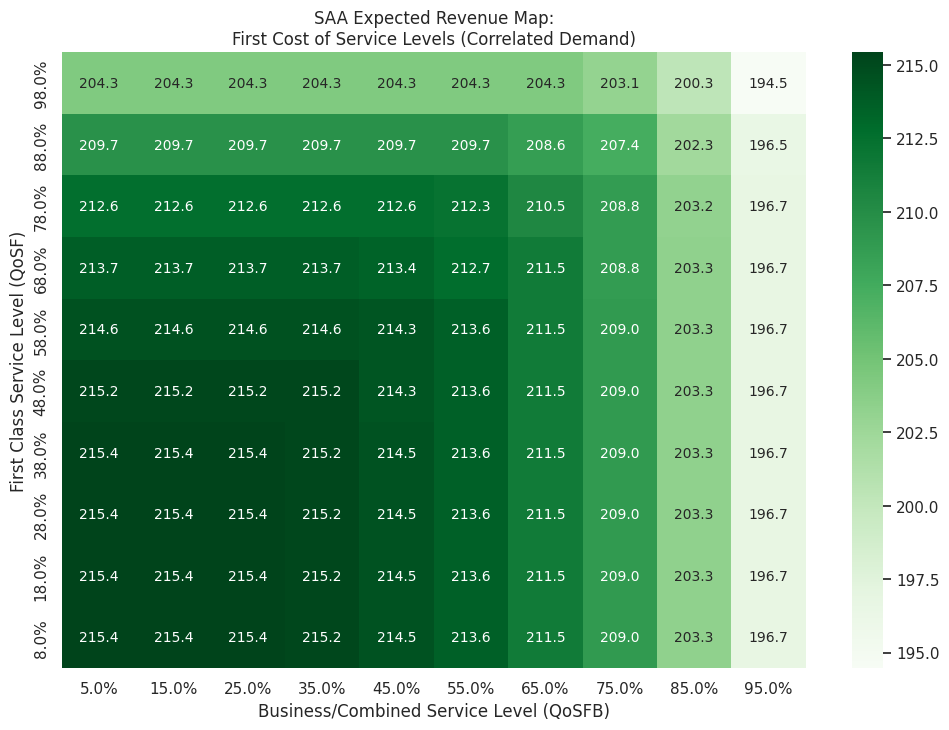

In [94]:
service_f = [f"{lvl*100:.1f}%" for lvl in f_service_lvl_range]
service_fb = [f"{lvl*100:.1f}%" for lvl in fb_service_lvl_range]

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    revenue_matrix,
    annot=True,
    fmt=".1f",
    annot_kws={"size": 10},
    xticklabels=service_fb,
    yticklabels=service_f,
    cmap="Greens"
)
ax.invert_yaxis()
plt.title("SAA Expected Revenue Map:\nFirst Cost of Service Levels (Correlated Demand)")
plt.xlabel("Business/Combined Service Level (QoSFB)")
plt.ylabel("First Class Service Level (QoSF)")
plt.show()

## Conclusions

This study successfully addressed the cabin configuration problem for Azul by applying mathematical rigor to the trade-offs between aircraft floor space and revenue potential. By leveraging Sample Average Approximation (SAA) and Mixed-Integer Linear Optimization (MILO), we transitioned from static "average" demand estimates to a robust model that accounts for real-world volatility and service-level constraints. Our findings reveal that the optimal configuration is defined by a strategic asymmetry: Economy functions as a high-utilization "revenue anchor," while Premium cabins serve as high-margin "buffers" that justify lower occupancy rates through superior revenue density. Through the use of grid search and sensitivity analysis on loyalty mandates, this notebook provides a data-driven roadmap for leadership to identify the Efficiency Frontier—the precise balance of seat allocation that satisfies strategic customer retention while maximizing the cash flow necessary for Azul's path toward long-term solvency.